# Objective

Following [variance_map_ps.ipynb](variance_map_ps.ipynb), now I try to implement the method given in Appendix A of Planck CO Revisited (Ghosh, S., et al.: A&A, 688, A54).

# Imports and Parameters

In [111]:
from pathlib import Path

import numpy as np
import healpy as hp
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

from handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [112]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTOR = 100
RANDOM_SEED = 42
PLANCK_SIM_NUM = 0
SMOOTHING = 10 / 60  # 10 arcminutes (in degrees)
BOXCAR_LENGTH = 10

In [113]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 2 * nside

# Display PS Helpers

In [114]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

In [115]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            labels=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        label = None if labels is None else labels[i]
        plt.plot(ps, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.legend()
    plt.show()

# Creating a Noise Map at $N_{side}=2048$

We first generate noise as used in CMB-ML for a full resolution map. 

(This section is the same as the other notebook)

In [116]:
obs_map_fn = get_planck_obs_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY)
use_nside_out = 2048

File /data/jim/CMB_Data/Assets/Planck/HFI_SkyMap_100_2048_R3.01_full.fits exists.


In [117]:
# Load the source map from Planck
planck_obs_path = Path(ASSETS_DIRECTORY) / obs_map_fn
II_cov_field = 4
II_cov_map = hp.read_map(planck_obs_path, hdu=1, field=II_cov_field)

assert use_nside_out == hp.get_nside(II_cov_map)  # Make sure we're using the right nside

In [118]:
# Create a "scale factor" map for the noise
scale_map = np.sqrt(II_cov_map)  # II_cov_map contains variance values; we need standard deviation for rng.normal()
scale_map = scale_map * 1e6  # convert to uK_CMB

In [119]:
# Generate the random noise map; calculate its power spectrum
rng = np.random.default_rng(RANDOM_SEED)
wht_map = rng.normal(size=scale_map.shape) * scale_map

lmax_2048 = get_lmax_for_nside(use_nside_out)  # Defined above as 3*Nside-1
ells_2048 = np.arange(lmax_2048 + 1)
wht_cl = hp.anafast(wht_map, lmax=lmax_2048)

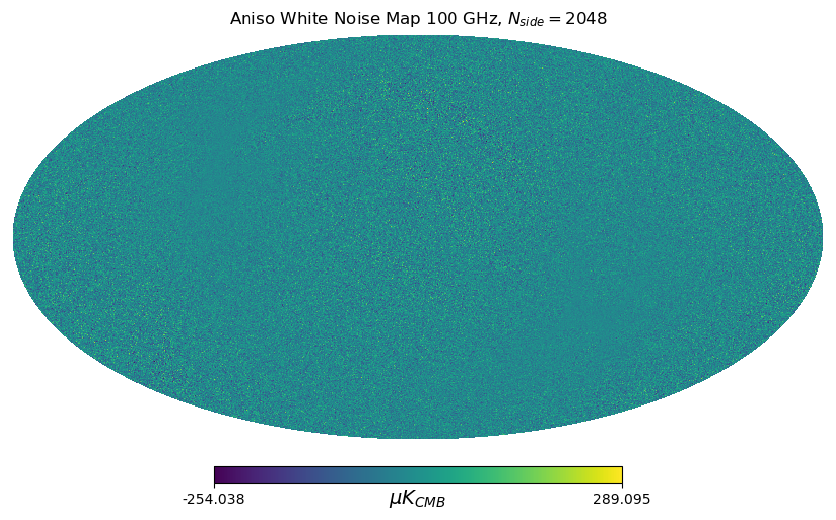

In [120]:
hp.mollview(wht_map, unit="$\\mu K_{CMB}$", 
            title="Aniso White Noise Map" + f" {DETECTOR} GHz, " + "$N_{side}" + f"={use_nside_out}$")

In [121]:
assert hp.npix2nside(wht_map.shape[0]) == 2048
print(f"We confirm that the map is resolution {hp.npix2nside(wht_map.shape[0])}")

We confirm that the map is resolution 2048


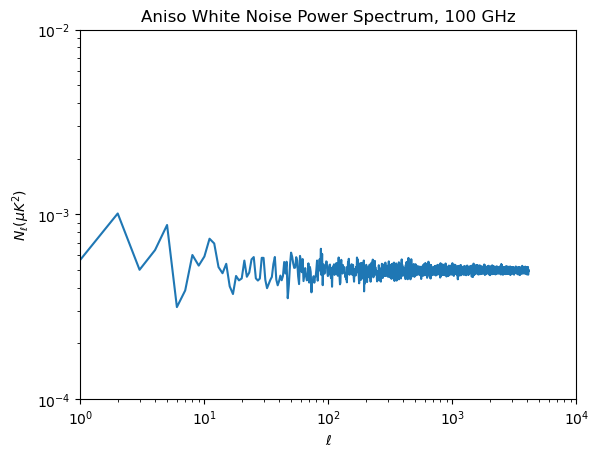

In [122]:
# Add the white noise level line to the plot; see if it matches expectations
plot_ps(wht_cl, title=f"Aniso White Noise Power Spectrum, {DETECTOR} GHz")

It looks like white noise at roughly 1e-4 $\mu K^2$.

# Getting Power Spectrum of Sim Noise

I'm trying this out first. It seems like I should be able to apply the method to a single map, as opposed to 5 maps simultaneously. I'm unsure about that though, as the result is not what I'd like.

Method (from Appendix A):
- Get simulation (Sim) with correct anisotropy (not listed as a step in Appendix A)
- Step 1: Generate white noise temperature map (WhT) as above
- Step 2: Smooth WhT to 10' in alm space (WAS)
- Step 3: Compute Cl^TT of WAS (WCl)
- Step 4: Compute Cl^TT of Sim (SCl)
- Step 5: Multiply WAS by SCl^{1/2} * WCl^{-1/2} (element-wise, since these are vectors?)
    - Tried with and without boxcar filter

In [123]:
# Step 0
nse_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=PLANCK_SIM_NUM)
nse_map = hp.read_map(nse_map_fn) * 1e6
nse_map.shape

File /data/jim/CMB_Data/Assets/Planck/ffp10_noise_100_full_map_mc_00000.fits exists.


(50331648,)

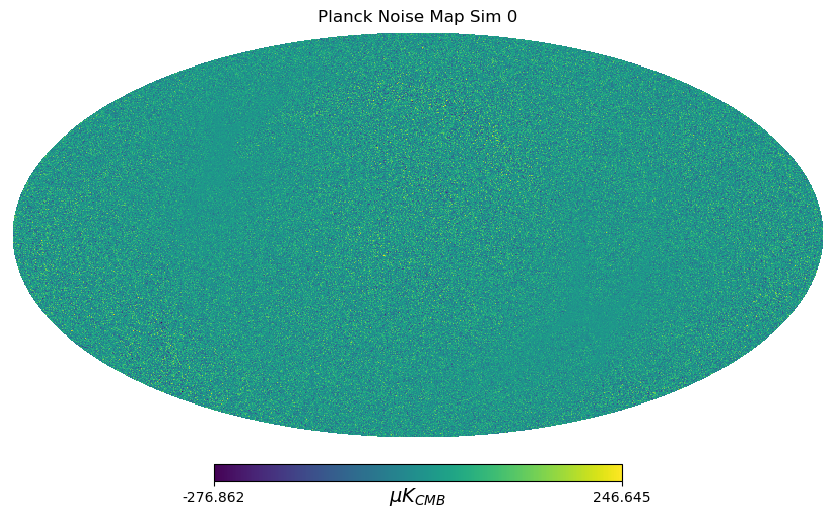

In [124]:
# Plot the loaded map, to ensure there's nothing goofy going on
hp.mollview(nse_map, unit="$\\mu K_{CMB}$", title=f"Planck Noise Map Sim {PLANCK_SIM_NUM}")

In [125]:
# Step 1: Get white noise map - Done above in previous section
#         (Cell is deliberately empty)

In [126]:
# Step 2: Smooth white noise map in alm domain
wht_alm = hp.map2alm(wht_map, lmax=lmax_2048)

In [127]:
# Step 3: Get PS of smoothed white noise map
wht_cl = hp.alm2cl(wht_alm, lmax=lmax_2048, lmax_out=lmax_2048)

In [128]:
# Step 4: Get PS of simulated map
nse_alm = hp.map2alm(nse_map, lmax=lmax_2048)
nse_cl = hp.alm2cl(nse_alm)  # This is for curiosity's sake

In [129]:
# Step 5: Create filter, mulitply alms by filter
def make_filter(boxcar_length, target_cl, source_cl):
    f = np.sqrt(target_cl / source_cl)
    boxcar = np.ones(boxcar_length)
    f = np.pad(f, (boxcar_length // 2, boxcar_length // 2), mode='edge')
    f = np.convolve(f, boxcar, mode='same') / np.sum(boxcar)
    return f

my_filter = make_filter(BOXCAR_LENGTH, nse_cl, wht_cl)
out_alm = hp.almxfl(wht_alm, my_filter)

In [130]:
out_map = hp.alm2map(out_alm, nside=use_nside_out, lmax=lmax_2048)

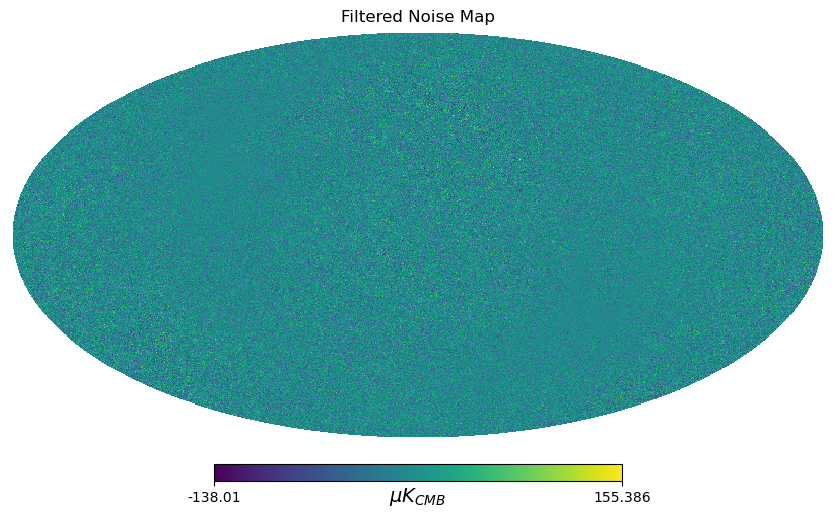

In [131]:
hp.mollview(out_map, unit="$\\mu K_{CMB}$", title="Filtered Noise Map")

In [132]:
out_map2ps = hp.anafast(out_map, lmax=lmax_2048)

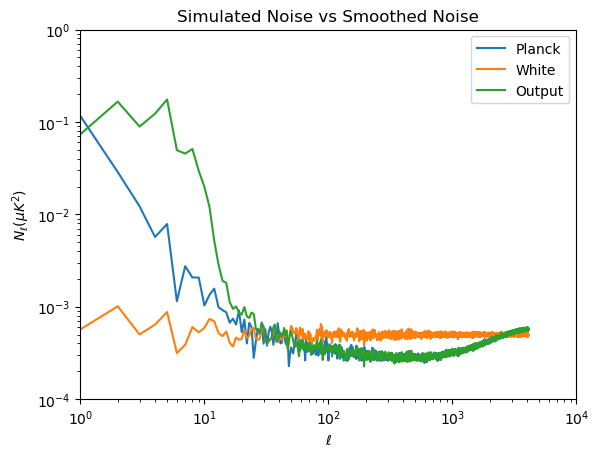

In [133]:
plot_many_ps([
              nse_cl, 
              wht_cl, 
              out_map2ps
              ], 
              labels=[
                  "Planck", 
                  "White", 
                  "Output"
                  ],
              y_high=1,
              title="Simulated Noise vs Smoothed Noise")